# Advanced Twitter Graph Insights

In this notebook, we dive deeper into our Twitter graph data to uncover interesting patterns.

## Outline:
1. **Setup and Load**: Load the pickled graph and create a DataFrame.
2. **High In-Degree vs. Follower Ratio**: Identify accounts that have a high in-degree (≥ 100) but relatively low total followers (i.e. large \( \frac{\text{in_degree}}{\text{follower_count}} \)).
3. **Correlation**: Re-check correlation between pagerank and follower count.
4. **High PageRank, Low Followers**: Find accounts that punch above their weight in terms of influence.
5. **Visual Analyses**: Scatter plots, histograms, and more.

Let's begin!

In [1]:
# Step 1: Imports
import pickle
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid')
%matplotlib inline

## Load Graph and Prepare DataFrame
We'll load the same `graph_with_pagerank.pickle` file from before and create our DataFrame with node-level attributes.

In [2]:
pickle_path = Path('graph_with_pagerank.pickle')  # Adjust if needed
with open(pickle_path, 'rb') as f:
    G = pickle.load(f)

print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Convert node attributes to DataFrame
node_data = []
for node, attrs in G.nodes(data=True):
    node_data.append({
        'user_id': node,
        'username': attrs.get('username', 'unknown'),
        'follower_count': attrs.get('follower_count', 0),
        'following_count': attrs.get('following_count', 0),
        'is_verified': attrs.get('is_verified', 0),
        'pagerank_score': attrs.get('pagerank_score', 0.0)
    })

df = pd.DataFrame(node_data)

# Compute in_degree and out_degree from the graph
in_degs = dict(G.in_degree())
out_degs = dict(G.out_degree())
df['in_degree'] = df['user_id'].map(in_degs)
df['out_degree'] = df['user_id'].map(out_degs)

print("DataFrame shape:", df.shape)
df.head()

Loaded graph with 2058497 nodes and 15832181 edges.
DataFrame shape: (2058497, 8)


,user_id,username,follower_count,following_count,is_verified,pagerank_score,in_degree,out_degree
0,1000005464,resolutemex,6607,366,0,0.020963,188,363
1,1003316046655381504,thecryptocactus,66739,230,0,0.051602,460,0
2,1004220018,0xAnteater,19339,3610,0,0.059957,774,2064
3,1007179644825726976,cryptochimpanz,33580,423,0,0.024860,187,0
4,1008431216796798977,btc_charlie,122452,570,0,0.086287,767,0


## 2. High In-Degree vs. Follower Ratio
We want accounts with:
- **in_degree** ≥ 100
- A high ratio \(\frac{\text{in_degree}}{\text{follower_count}}\)

If \(\text{follower_count}\) is 0 or extremely small, we handle that carefully to avoid division by zero. Let's define a new column `in_deg_to_followers` and sort.

In [3]:
# Replace any 0 follower_count with 1 to avoid division by zero
df['follower_count_safe'] = df['follower_count'].replace(0, 1)
df['in_deg_to_followers'] = df['in_degree'] / df['follower_count_safe']

# Filter by in_degree >= 100
filtered = df[df['in_degree'] >= 100].copy()
filtered.sort_values('in_deg_to_followers', ascending=False, inplace=True)

print("Number of accounts with in_degree >= 100:", len(filtered))
filtered[['user_id','username','in_degree','follower_count','in_deg_to_followers']].head(20)

Number of accounts with in_degree >= 100: 24286


,user_id,username,in_degree,follower_count,in_deg_to_followers
43874,1848825418813759488,The_Hedgooor,114,261,0.436782
130127,549809070,Ashwinningg,125,494,0.253036
120043,1793491780710850561,sfonchain,123,492,0.250000
88043,1861459187277946880,tervoalt,136,557,0.244165
104744,1548211882204418049,valentinmadrid_,178,779,0.228498
210161,823560541604118528,meganenright_,171,760,0.225000
43743,1676877293367488512,ZKpdgSmith62D9,105,480,0.218750
130058,1765115365074575360,ABKLABS,102,469,0.217484
181341,1383704480772886531,0xShuk,108,497,0.217304
141233,1505330108160266241,MightyMvrk,131,612,0.214052


### Observation
A high `in_deg_to_followers` ratio often means the account is more followed **within our dataset** than you'd expect from their publicly reported `follower_count`. This can mean:
- They are known/connected in this sub-network.
- Their external (total Twitter) follower count might not reflect the community's interest in them.


## 3. Correlation Check
Earlier we saw a low correlation (≈0.168) between PageRank and follower_count. Let's confirm again and do a scatterplot to identify interesting outliers.

Correlation between pagerank_score and follower_count: 0.187


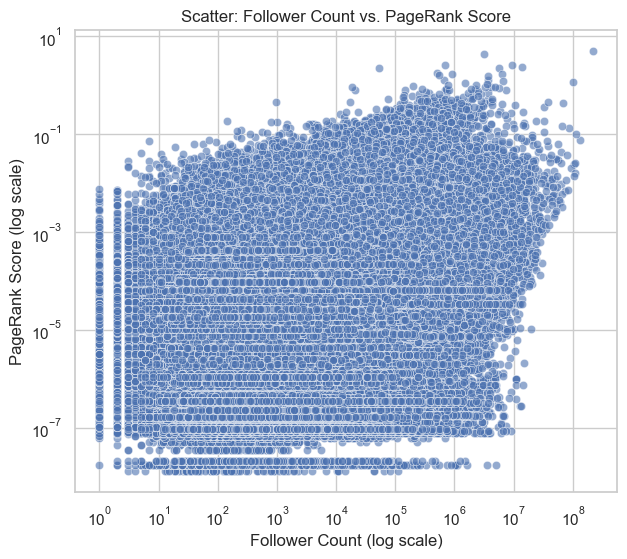

In [4]:
# Calculate correlation
corr_matrix = df[['pagerank_score','follower_count']].corr()
corr_val = corr_matrix.iloc[0,1]
print(f"Correlation between pagerank_score and follower_count: {corr_val:.3f}")

# Scatterplot
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df, x='follower_count', y='pagerank_score', alpha=0.6
)
plt.xscale('log')  # scale for clarity
plt.yscale('log')
plt.title('Scatter: Follower Count vs. PageRank Score')
plt.xlabel('Follower Count (log scale)')
plt.ylabel('PageRank Score (log scale)')
plt.show()

### Interpretation
A low correlation means that having a large follower count doesn’t necessarily imply a high PageRank in **this** subgraph. PageRank accounts for network structure, so an account can be heavily followed by *less influential* accounts (which lowers their rank), or can be modestly followed by *highly influential* accounts (which raises their rank).

## 4. High PageRank, Low Followers
We want to zero-in on accounts that have a relatively **high** PageRank score but **lower** follower counts. These are interesting because they might be highly influential in the local network despite not having a massive Twitter following overall.

### Strategy:
1. Determine thresholds for `pagerank_score` (e.g. 75th percentile for “high”).
2. Determine thresholds for `follower_count` (e.g. 25th percentile for “low”).
3. Filter on those two conditions.

In [21]:
pr_high_threshold = df['pagerank_score'].quantile(0.99)
followers_low_threshold = df['follower_count'].quantile(.25)

print(f"75th percentile PageRank threshold: {pr_high_threshold:.6f}")
print(f"25th percentile Follower threshold: {followers_low_threshold}")

high_PR_low_followers = df[
    (df['pagerank_score'] >= pr_high_threshold) & 
    (df['follower_count'] <= followers_low_threshold)
]

print(f"Number of accounts with high PageRank and low follower counts: {len(high_PR_low_followers)}")
high_PR_low_followers[['user_id','username','follower_count','pagerank_score','in_degree','out_degree']].sort_values('pagerank_score', ascending=False).head(20)

75th percentile PageRank threshold: 0.010163
25th percentile Follower threshold: 156.0
Number of accounts with high PageRank and low follower counts: 187


,user_id,username,follower_count,pagerank_score,in_degree,out_degree
228335,1701656626032435200,parafitech,143,0.184300,8,0
930679,1196636639793012737,Denigma_,70,0.078050,6,0
1341816,1755379965535854592,NftsAreDeadNot,7,0.071736,1,0
878759,1882530160202706944,p5_Progressions,93,0.069695,5,0
1108848,1845603710656757760,oddcoregame,39,0.064082,1,0
425036,274706215,bananica88,56,0.063633,1,0
825637,1510858202954436611,greenhouselotus,19,0.054185,1,0
764838,1859553818775781376,nanipilled,143,0.054086,13,0
687736,1655833148,fosterfication,118,0.051680,3,0
752598,1854751235943153664,ProductBPaper,63,0.045899,5,0


These accounts might be excellent “local influencers” or very well-connected in the sub-network. They may be followed by already influential accounts, amplifying their PageRank.

### Visualizing That Subset

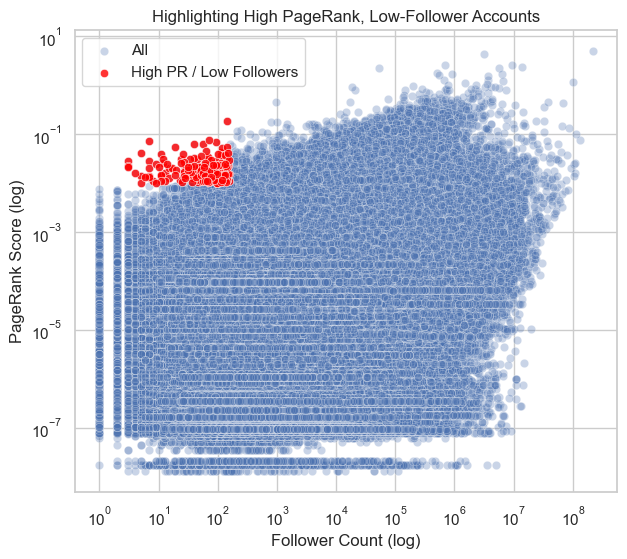

In [22]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df, x='follower_count', y='pagerank_score', alpha=0.3, label='All'
)
sns.scatterplot(
    data=high_PR_low_followers, x='follower_count', y='pagerank_score', 
    color='red', alpha=0.8, label='High PR / Low Followers'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Follower Count (log)')
plt.ylabel('PageRank Score (log)')
plt.title('Highlighting High PageRank, Low-Follower Accounts')
plt.legend()
plt.show()

## 5. Additional Visual Breakdowns
Below are a couple of extra histograms for `pagerank_score` and `follower_count`. You can easily adapt these for any deeper analysis you want.

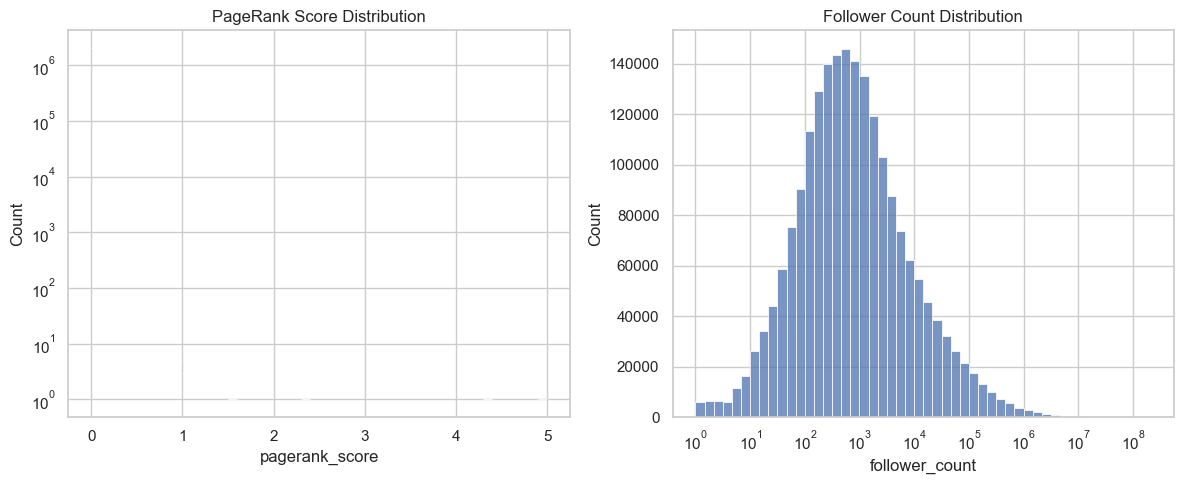

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['pagerank_score'], ax=axes[0], bins=50, log_scale=(False, True))
axes[0].set_title('PageRank Score Distribution')

sns.histplot(df['follower_count'], ax=axes[1], bins=50, log_scale=(True, False))
axes[1].set_title('Follower Count Distribution')

plt.tight_layout()
plt.show()

In [16]:
def search_account(username, df, G):
    """
    Search for an account by username and display its details
    """
    # Case insensitive search
    account = df[df['username'].str.lower() == username.lower()]
    
    if len(account) == 0:
        # Try partial match if exact match not found
        account = df[df['username'].str.lower().str.contains(username.lower())]
        if len(account) > 0:
            print(f"Found {len(account)} accounts containing '{username}':")
            return account[['username', 'follower_count', 'following_count', 'pagerank_score', 'is_verified']]
        else:
            print(f"No accounts found containing '{username}'")
            return None
    
    # Get the account details
    account_data = account.iloc[0]
    user_id = account_data['user_id']
    
    # Calculate PageRank percentile
    pagerank_percentile = 100 * (df['pagerank_score'] < account_data['pagerank_score']).mean()
    
    # Get followers and following
    followers = list(G.predecessors(user_id))
    following = list(G.successors(user_id))
    
    # Get top followers by PageRank
    follower_ranks = [(f, G.nodes[f].get('pagerank_score', 0)) for f in followers]
    top_followers = sorted(follower_ranks, key=lambda x: x[1], reverse=True)[:10]
    
    print("\nAccount Details:")
    print(f"Username: {account_data['username']}")
    print(f"Follower Count: {account_data['follower_count']:,}")
    print(f"Following Count: {account_data['following_count']:,}")
    print(f"PageRank Score: {account_data['pagerank_score']:.6f}")
    print(f"PageRank Percentile: {pagerank_percentile:.2f}%")
    print(f"Verified: {'Yes' if account_data['is_verified'] else 'No'}")
    
    print(f"\nNetwork Statistics:")
    print(f"Actual Followers in Dataset: {len(followers):,}")
    print(f"Actual Following in Dataset: {len(following):,}")
    print(f"Reciprocal Connections: {len(set(followers) & set(following)):,}")
    
    print("\nTop 10 Most Influential Followers:")
    for f, rank in top_followers:
        f_name = G.nodes[f].get('username', 'unknown')
        f_followers = G.nodes[f].get('follower_count', 0)
        print(f"- {f_name} (PageRank: {rank:.6f}, Followers: {f_followers:,})")
    
    return account_data

# Search for the account
search_account("daribigboss", df, G)



Account Details:
Username: daribigboss
Follower Count: 3,473,079
Following Count: 23,235
PageRank Score: 0.001193
PageRank Percentile: 93.54%
Verified: No

Network Statistics:
Actual Followers in Dataset: 20
Actual Following in Dataset: 0
Reciprocal Connections: 0

Top 10 Most Influential Followers:
- helloimthatdude (PageRank: 0.022523, Followers: 172,718)
- DeLoreanlabs (PageRank: 0.020168, Followers: 101,401)
- playWAM (PageRank: 0.012778, Followers: 77,479)
- PushpendraTech (PageRank: 0.011655, Followers: 137,219)
- BNBTC_on_BSC (PageRank: 0.007326, Followers: 10,544)
- PopeSmokeX (PageRank: 0.006990, Followers: 10,134)
- Jstn0x (PageRank: 0.006756, Followers: 43,132)
- AIFlow_ML (PageRank: 0.006585, Followers: 3,997)
- ChronicleXNL (PageRank: 0.006098, Followers: 14,970)
- TonenUp (PageRank: 0.005451, Followers: 2,291)


user_id                  203762854
username               daribigboss
follower_count             3473079
following_count              23235
is_verified                      0
pagerank_score            0.001193
in_degree                       20
out_degree                       0
follower_count_safe        3473079
in_deg_to_followers       0.000006
Name: 321937, dtype: object

## Conclusions & Next Steps
1. **High in-degree ratio** can reveal nodes that are abnormally influential in this dataset.
2. **Low correlation** between PageRank and follower count suggests PageRank captures deeper network structure.
3. **High PageRank, low follower** accounts might be rising stars, or highly respected in the sub-community despite modest total follower counts.

**Possible next steps**:
- Investigate a handful of these “hidden gem” accounts manually.
- See if adding more weight to verified accounts or other modifications changes the results.
- Expand to a time-based analysis if multiple snapshots are available.

Feel free to refine or extend these cells based on your analysis needs!